In [1]:
import os

def change_dir_in_hipergator():
    # this env var is set on hipergator (SLURM is the job scheduler there)
    if os.getenv("SLURM_JOB_ID", None):
        target_dir = "diff_fam_social_memory_ephys"
        current = os.getcwd()

        while True:
            parent = os.path.dirname(current)
            # If we've reached the root directory without finding the target
            if parent == current:
                raise FileNotFoundError(f"Could not find parent directory '{target_dir}'")

            # Check if the target directory is the current parent's name
            if os.path.basename(parent) == target_dir:
                os.chdir(parent)
                return parent

            current = parent

# Usage
try:
    new_path = change_dir_in_hipergator()
    print(f"Successfully changed to directory: {new_path}")
except FileNotFoundError as e:
    print(e)

Successfully changed to directory: None


In [43]:
import pickle
import behavior.boris_extraction as boris
#import spike.spike_analysis. as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import sem
from itertools import combinations
import pandas as pd
import os
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

In [40]:
behavior_dfs = {}
path = r"C:\Users\megha\Documents\Padilla-Coreano\homecage_social_ephys_vids\pilot2\boris\object\aggregated_csvs"
for file in os.listdir(path):
    if file.endswith(".csv"):
        behavior_dfs[file] = pd.read_csv(os.path.join(path, file))


In [88]:

def random_event_generator(start, stop, len_event, no_events):
    total_duration = stop - start
    possible_events = np.arange(int(total_duration / len_event))
    pot_events = np.random.choice(possible_events, size = (no_events), replace = False)
    pot_events = np.sort(pot_events)
    events = []
    for i in pot_events: 
        event_start = (start + (len_event * i)) * 1000
        event_stop = (event_start + (len_event * 1000))
        events.append(np.array([event_start, event_stop]))
    return(np.array(events))

22_object_CTBN.csv
12
23_object_TBCN.csv
12
31_object_BNTC.csv
12
32_object_NBTC.csv
12
41_object_BCNT.csv
12
44_Object_TCNB.csv
12


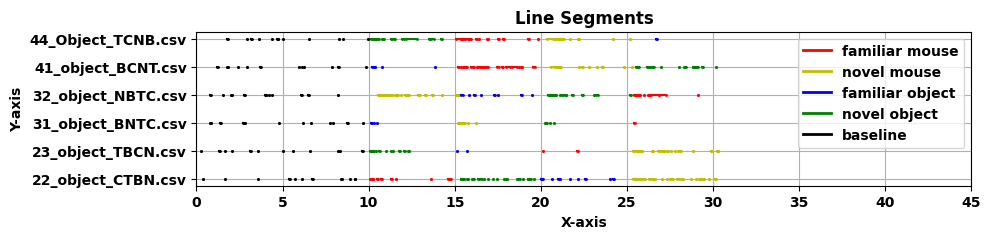

In [94]:
behavior_dicts = {}
min_bout = 0.5
min_iti = 1
subject = ['subject']
behavior = ['anogenital sniffing', 'facial sniffing', 'sniffing object']
order_dict = {'T': 'novel object', 'B': 'familiar object', 'N': 'novel mouse', 'C': 'familiar mouse'}
for filename, df in behavior_dfs.items():
    # try:
    #     file_name = list(df['Media file'].unique())[0]
    # except KeyError:
    #     file_name = list(df['Media file name'].unique())[0]
    # temp_filename = file_name.split("/")[-1].split("_")
    # filename = temp_filename[0] + "_" + temp_filename[1]
    print(filename)
    mouse_in = list(df[df['Behavior'] == 'mice back in']['Start (s)'])
    mouse_out = list(df[df['Behavior'] == 'mice taken out']['Start (s)'])
    if filename == '23_object_TBCN.csv':
        mouse_in.insert(0, 602)
        mouse_out.insert(0, 900)
        mouse_in.insert(1, 902)
        mouse_out.insert(1, 1201)
    if filename == '32_object_NBTC.csv': 
        mouse_in.insert(1, 922)
        mouse_in.insert(2, 1222)
        mouse_out.insert(1, 1222)
        mouse_out.insert(2,1521)
    if filename == '31_object_BNTC.csv':
        mouse_in.insert(0, 608)
        mouse_in.insert(2, 1213)
        mouse_out.insert(0, 906)
        mouse_out.insert(2,1521)
    df_1 = df[df['Start (s)'] < mouse_out[0]]
    df_2 = df[(df['Start (s)'] > mouse_in[1]) &
            (df['Start (s)'] < mouse_out[1])]
    df_3 = df[(df['Start (s)'] > mouse_in[2]) &
            (df['Start (s)'] < mouse_out[2])]
    df_4 = df[(df['Start (s)'] > mouse_in[3])]
    arrays = []
    arrays.append(boris.get_behavior_bouts(df_1,
                                    subject = subject,
                                    behavior = behavior,
                                    min_bout = min_bout,
                                    min_iti = min_iti))
    arrays.append(boris.get_behavior_bouts(df_2,
                                    subject = subject,
                                    behavior = behavior,
                                    min_bout = min_bout,
                                    min_iti = min_iti))
    arrays.append(boris.get_behavior_bouts(df_3,    
                                    subject = subject,
                                    behavior = behavior,
                                    min_bout = min_bout,
                                    min_iti = min_iti))
    arrays.append(boris.get_behavior_bouts(df_4,        
                                    subject = subject,
                                    behavior = behavior,
                                    min_bout = min_bout,
                                    min_iti = min_iti))
    baseline_array = random_event_generator(0, mouse_in[0], 1, 12)
    print(len(baseline_array))                                
    order = filename.split("_")[-1].split(".")[0]
    behavior_dict = {}
    for i in range(len(order)):
        behavior_dict[f'{order_dict[order[i]]}'] = arrays[i]
    behavior_dict['baseline'] = baseline_array
    behavior_dicts[filename] = behavior_dict
    

color_dict = {'familiar mouse': 'r', 'novel mouse': 'y', 'familiar object': 'b', 'novel object': 'g',
              'baseline' : 'k'}
recording_number = 0
plt.figure(figsize = (10,2))
labels = []
for name, recording in behavior_dicts.items():
    labels.append(name)
    for event, snippets in recording.items():
        if (event =='familiar mouse'
            ) | (event == 'familiar object'
                 ) | (event == 'novel object'
                      ) | (event == 'novel mouse') | (event == 'baseline'):
            for i in range(len(snippets)):
                y = [recording_number,recording_number]
                x = snippets[i]/1000/60
            # Plot the line segments
                plt.plot(x, y, marker='o', linestyle='-', c= color_dict[event], markersize = 1)
    recording_number += .5
# Optionally, you can add labels, title, etc.
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.yticks(ticks=np.arange(len(labels))/2, labels=labels)
plt.title('Line Segments')
legend_labels = [plt.Line2D([0], [0], color=color_dict[label], lw=2, label=label) for label in color_dict]
plt.legend(handles=legend_labels)
plt.grid(True)
plt.xlim([0,45])
plt.show()


In [95]:
event_info = {}
sniff_itis = []
j = 0
total_sniffs = 0
subject_info = {}
for subject, behavior_dict in behavior_dicts.items():
    event_dict_keys = behavior_dict.keys()
    for event, events in behavior_dict.items():
        no_events = events.shape[0]
        sniff_length = 0
        for i in range(len(events)):
            sniff_length_temp = events[i][1] - events[i][0]
            sniff_length = sniff_length + sniff_length_temp
            total_sniffs = total_sniffs + 1
            try:
                sniff_iti = events[i+1][0] - events[i][1]
                sniff_itis.append(sniff_iti)
            except IndexError:
                pass
        total_sniff_time = sniff_length/1000
        try:
            avg_event = sniff_length/no_events/1000
        except ZeroDivisionError:
            avg_event = 0
        if subject in event_info.keys():
            dict_event = event_info[subject]
            dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
            event_info[subject] =  dict_event
        else:
            event_info[subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
    j += 1
sniff_itis = np.array(sniff_itis)/1000
sniff_itis 
overlapping_sniffs = 0 
for i in range(len(sniff_itis)):
    if sniff_itis[i] < 1:
        overlapping_sniffs = overlapping_sniffs + 1
print(overlapping_sniffs) # was 54 with old thresholding for less than 2, 142 for 5
print(total_sniffs)

3
358


In [96]:
data_points = []
subjects = []
behaviors = []
for subject, dict in event_info.items():
    #iterating through subject
    event_list = []
    subjects.append(subject)
    for event, times in dict.items():
        #iterating through event
        event_list.append(times['total time'])
        behaviors.append(event)
    data_points.append(event_list)
data_points = np.array(data_points).T
print(subjects)
print(behaviors)
print(data_points.shape)
print(data_points.shape)

['22_object_CTBN.csv', '23_object_TBCN.csv', '31_object_BNTC.csv', '32_object_NBTC.csv', '41_object_BCNT.csv', '44_Object_TCNB.csv']
['familiar mouse', 'novel object', 'familiar object', 'novel mouse', 'baseline', 'novel object', 'familiar object', 'familiar mouse', 'novel mouse', 'baseline', 'familiar object', 'novel mouse', 'novel object', 'familiar mouse', 'baseline', 'novel mouse', 'familiar object', 'novel object', 'familiar mouse', 'baseline', 'familiar object', 'familiar mouse', 'novel mouse', 'novel object', 'baseline', 'novel object', 'familiar mouse', 'novel mouse', 'familiar object', 'baseline']
(5, 6)
(5, 6)


In [97]:
event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()
event_dict_keys
event_overview
event_temp = event_overview.drop('level_0', axis = 1)
event_overview_averages = event_temp.groupby('level_1').mean()
event_overview_averages

,familiar mouse,novel object,familiar object,novel mouse,baseline
level_1,,,,,
avg event,2.989263,2.390282,1.668293,2.583410,1.0
no_events,10.166667,14.833333,4.833333,17.833333,12.0
total time,38.997000,36.007333,8.086000,43.055500,12.0


In [98]:
event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_agent_time_averages = {}
avg_events = []
sem_events = []
for event in event_dict_keys:
    if 'cup' not in event:
        avg_event = event_total_time[event].mean()
        sem_event = sem(event_total_time[event])
        event_agent_time_averages[event] = (avg_event, sem_event)
        avg_events.append(avg_event)
        sem_events.append(sem_event)
avg_events = np.array(avg_events)
sem_events = np.array(sem_events)
event_agent_time_averages

{'novel object': (36.00733333333333, 11.812612662366913),
 'familiar mouse': (38.99699999999998, 13.951846174132886),
 'novel mouse': (43.0555, 6.120996159395408),
 'familiar object': (8.08599999999998, 2.337258222790109),
 'baseline': (12.0, 0.0)}

['22_object_CTBN.csv', '23_object_TBCN.csv', '31_object_BNTC.csv', '32_object_NBTC.csv', '41_object_BCNT.csv', '44_Object_TCNB.csv']
familiar mouse
[25.197 20.732  5.2   59.801 10.25  89.467]
novel object
[37.132  4.067 16.6   10.933 80.652 57.999]
familiar object
[16.933  2.601  3.801 36.401 40.013 47.001]
novel mouse
[53.787 41.131  0.8   66.733 28.511  1.133]
baseline
[12. 12. 12. 12. 12. 12.]


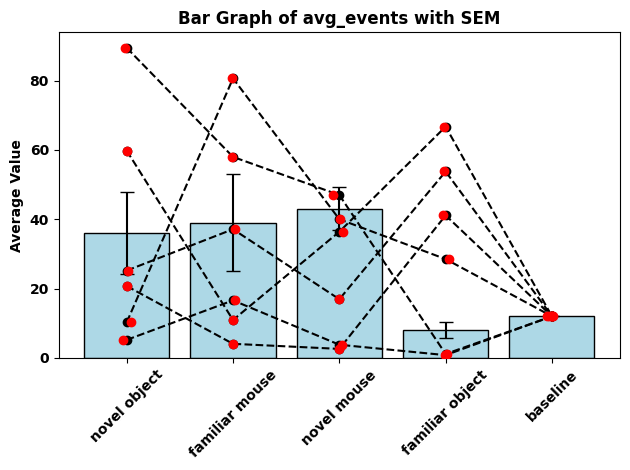

In [99]:
print(subjects)
x = np.arange(len(avg_events))
labels = event_agent_time_averages.keys()
# Create the bar plot
plt.bar(x, avg_events, yerr=sem_events, capsize=5, color='lightblue', edgecolor='black')
for i, group_data in enumerate(data_points):
    print(behaviors[i])
    print(data_points[i])
    # Spread the points a little horizontally to avoid overlap (add a small random jitter)
    jitter = np.random.normal(0, 0.02, size=len(group_data))
    plt.scatter([i + jitter_val for jitter_val in jitter], group_data, color='red', zorder=5)
for j in range(len(data_points[0])):  # Assuming all groups have the same number of data points
    x_vals = np.arange(len(data_points))  # X positions for all groups
    y_vals = [data_points[i][j] for i in range(len(data_points))]  # Y values for the same index
    plt.plot(x_vals, y_vals, color='black', linestyle='--', marker='o', zorder=4)

# Add labels and title
plt.xticks(x, labels, rotation = 45)
plt.ylabel('Average Value')
plt.title('Bar Graph of avg_events with SEM')

# Show the plot
plt.tight_layout()
plt.show()


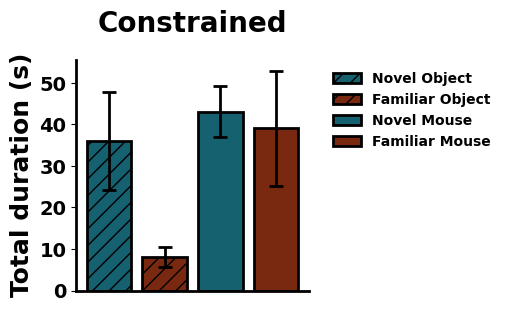

In [100]:
event_agent_time_averages 
avg_events = [event_agent_time_averages['novel object'][0], 
              event_agent_time_averages['familiar object'][0],
              event_agent_time_averages['novel mouse'][0],
              event_agent_time_averages['familiar mouse'][0]]
sem_events = [event_agent_time_averages['novel object'][1],
              event_agent_time_averages['familiar object'][1],
              event_agent_time_averages['novel mouse'][1],
              event_agent_time_averages['familiar mouse'][1]]

plt.rcParams['font.weight'] = 'bold'  # Set font weight to bold (not bold)
plt.rcParams['axes.titleweight'] = 'bold'  # Set axis title font weight to bold
plt.rcParams['axes.labelweight'] = 'bold'  # Set axis label font weight to bold

color_id_dict = {'novel object': hex_2_rgb('#15616F'),  
                'familiar object': hex_2_rgb('#792910'),
                'novel mouse': hex_2_rgb('#15616F'),
                'familiar mouse': hex_2_rgb('#792910'),}
                
hatches = ['//','//','','']  
plt.figure(figsize= (3,3))           
plt.bar(color_id_dict.keys(), avg_events, yerr = sem_events,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'], linewidth = 2,
            capsize = 5, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
plt.ylabel('Total duration (s)', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Constrained', fontsize = 20, pad = 20)
# Create custom legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color_id_dict['novel object'], edgecolor='black', linewidth=2, label='Novel Object', hatch = '//'),
    plt.Rectangle((0, 0), 1, 1, facecolor=color_id_dict['familiar object'], edgecolor='black', linewidth=2, label='Familiar Object', hatch = '//'),
    plt.Rectangle((0, 0), 1, 1, facecolor=color_id_dict['novel mouse'], edgecolor='black', linewidth=2, label='Novel Mouse'),
     plt.Rectangle((0, 0), 1, 1, facecolor=color_id_dict['familiar mouse'], edgecolor='black', linewidth=2, label='Familiar Mouse')
]

# Add the legend
plt.legend(handles=legend_elements, fontsize=10, frameon=False, loc='best', bbox_to_anchor=(1.05, 1))

In [101]:
total_time_df = event_overview[event_overview['level_1'] == 'total time']
avg_event_df = event_overview[event_overview['level_1'] == 'avg event']
no_events_df = event_overview[event_overview['level_1'] == 'no_events']

total_time_long_df = pd.melt(total_time_df, id_vars = ['level_0'],
                            value_vars = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse'],
                            var_name = 'condition', value_name = 'time')

avg_event_long_df = pd.melt(avg_event_df, id_vars = ['level_0'],
                            value_vars = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse'],
                            var_name = 'condition', value_name = 'time')

no_events_long_df = pd.melt(no_events_df, id_vars = ['level_0'],
                            value_vars = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse'],
                            var_name = 'condition', value_name = 'no of events')
total_time_long_df

,level_0,condition,time
0,22_object_CTBN.csv,novel object,37.132
1,23_object_TBCN.csv,novel object,20.732
2,31_object_BNTC.csv,novel object,3.801
3,32_object_NBTC.csv,novel object,36.401
4,41_object_BCNT.csv,novel object,28.511
5,44_Object_TCNB.csv,novel object,89.467
6,22_object_CTBN.csv,familiar object,16.933
7,23_object_TBCN.csv,familiar object,4.067
8,31_object_BNTC.csv,familiar object,5.200
9,32_object_NBTC.csv,familiar object,10.933


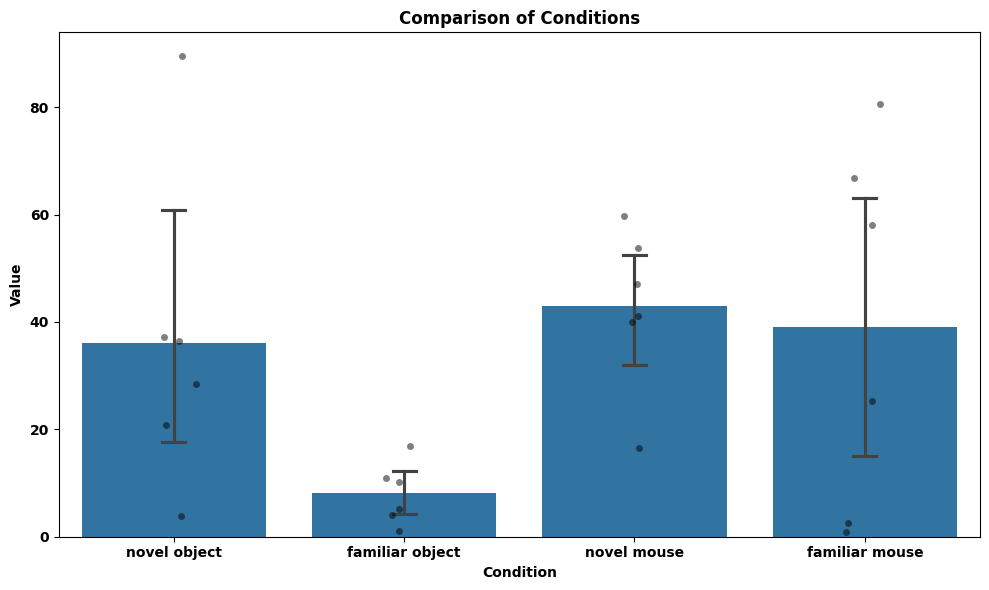

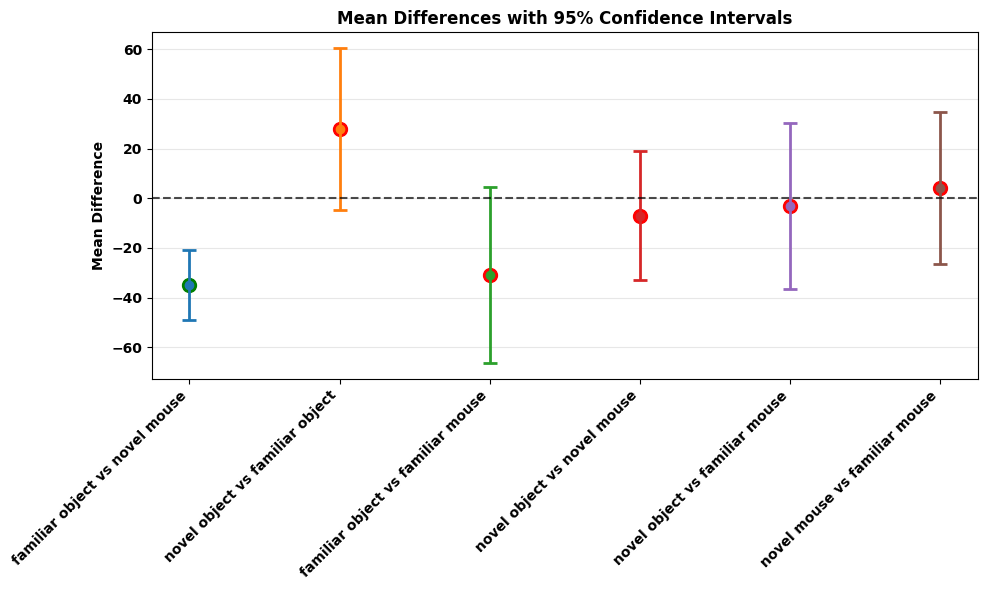

Paired t-test results with Holm-Bonferroni correction:
                          Comparison  t-statistic   p-value  p-value (Holm)  \
3     familiar object vs novel mouse    -6.375634  0.001405        0.008427   
0    novel object vs familiar object     2.208514  0.078251        0.371248   
4  familiar object vs familiar mouse    -2.250293  0.074250        0.371248   
1        novel object vs novel mouse    -0.699879  0.515218        1.000000   
2     novel object vs familiar mouse    -0.230304  0.826982        1.000000   
5      novel mouse vs familiar mouse     0.340051  0.747638        1.000000   

   Significant  Mean Difference   CI Lower   CI Upper  
3         True       -34.969500 -49.068798 -20.870202  
0        False        27.921333  -4.577479  60.420146  
4        False       -30.911000 -66.221622   4.399622  
1        False        -7.048167 -32.935342  18.839009  
2        False        -2.989667 -36.359423  30.380089  
5        False         4.058500 -26.621289  34.738289  

In [102]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

def paired_ttest_with_holm(data, conditions, subject_col='subject', value_col='value', alpha=0.05):
    """
    Perform paired t-tests between all pairs of conditions with Holm-Bonferroni correction.
    
    Parameters:
    -----------
    data : pandas DataFrame
        Data in long format with one row per subject-condition combination
    conditions : list
        List of condition names to compare
    subject_col : str
        Name of the column containing subject identifiers
    value_col : str
        Name of the column containing the measurement values
    alpha : float
        Significance level (default: 0.05)
    
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame containing the results of all pairwise comparisons
    """
    # Get all pairs of conditions
    pairs = [(c1, c2) for i, c1 in enumerate(conditions) for c2 in conditions[i+1:]]
    
    # Initialize lists to store results
    pair_names = []
    t_values = []
    p_values = []
    mean_diffs = []
    ci_lows = []
    ci_highs = []
    
    # Perform paired t-test for each pair
    for cond1, cond2 in pairs:
        # Get data for each condition, ensuring same subjects in both
        df1 = data[data['condition'] == cond1][[subject_col, value_col]].set_index(subject_col)
        df2 = data[data['condition'] == cond2][[subject_col, value_col]].set_index(subject_col)
        
        # Match subjects
        common_subjects = df1.index.intersection(df2.index)
        if len(common_subjects) == 0:
            raise ValueError(f"No common subjects found between {cond1} and {cond2}")
        
        values1 = df1.loc[common_subjects, value_col].values
        values2 = df2.loc[common_subjects, value_col].values
        
        # Perform paired t-test
        t_stat, p_val = stats.ttest_rel(values1, values2)
        
        # Calculate mean difference and confidence interval
        diff = values1 - values2
        mean_diff = np.mean(diff)
        
        # 95% confidence interval
        n = len(diff)
        sem = stats.sem(diff)
        ci_low, ci_high = stats.t.interval(1-alpha, n-1, loc=mean_diff, scale=sem)
        
        # Store results
        pair_names.append(f"{cond1} vs {cond2}")
        t_values.append(t_stat)
        p_values.append(p_val)
        mean_diffs.append(mean_diff)
        ci_lows.append(ci_low)
        ci_highs.append(ci_high)
    
    # Apply Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=alpha, method='holm')
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Comparison': pair_names,
        't-statistic': t_values,
        'p-value': p_values,
        'p-value (Holm)': p_corrected,
        'Significant': reject,
        'Mean Difference': mean_diffs,
        'CI Lower': ci_lows,
        'CI Upper': ci_highs
    })
    
    # Sort by corrected p-value
    results_df = results_df.sort_values('p-value (Holm)')
    plt.figure(figsize=(10, 6))
    sns.barplot(x='condition', y=data[value_col], data=data, capsize=0.1)
    sns.stripplot(x='condition', y=data[value_col], data=data, color='black', alpha=0.5)
    plt.title('Comparison of Conditions')
    plt.ylabel('Value')
    plt.xlabel('Condition')
    plt.tight_layout()
    plt.show()

    # Optional: Visualize the mean differences with confidence intervals
    plt.figure(figsize=(10, 6))
    for i, (idx, row) in enumerate(results_df.iterrows()):
        plt.errorbar(
            x=i, 
            y=row['Mean Difference'],
            yerr=[[row['Mean Difference']-row['CI Lower']], [row['CI Upper']-row['Mean Difference']]],
            fmt='o', capsize=5, capthick=2, elinewidth=2
        )
        color = 'green' if row['Significant'] else 'red'
        plt.scatter(i, row['Mean Difference'], color=color, s=100)

    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    plt.xticks(range(len(results_df)), results_df['Comparison'], rotation=45, ha='right')
    plt.title('Mean Differences with 95% Confidence Intervals')
    plt.ylabel('Mean Difference')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results_df

conditions = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse']
subjects = event_overview['level_0'].unique  # 10 subjects

# Run the analysis
results = paired_ttest_with_holm(total_time_long_df, conditions, subject_col='level_0', value_col='time')

# Print results
print("Paired t-test results with Holm-Bonferroni correction:")
print(results)

# Optional: Create a visualization

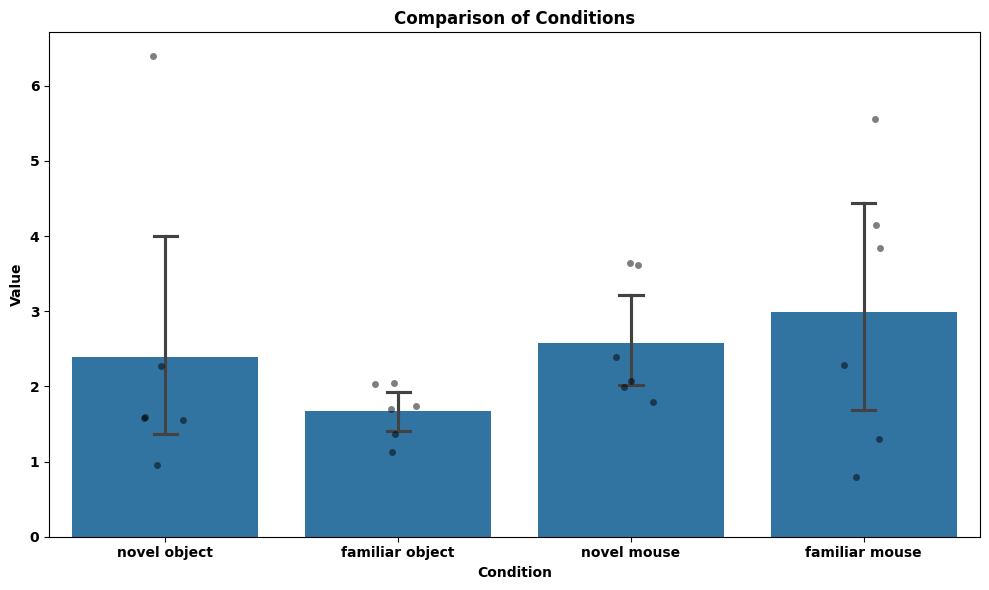

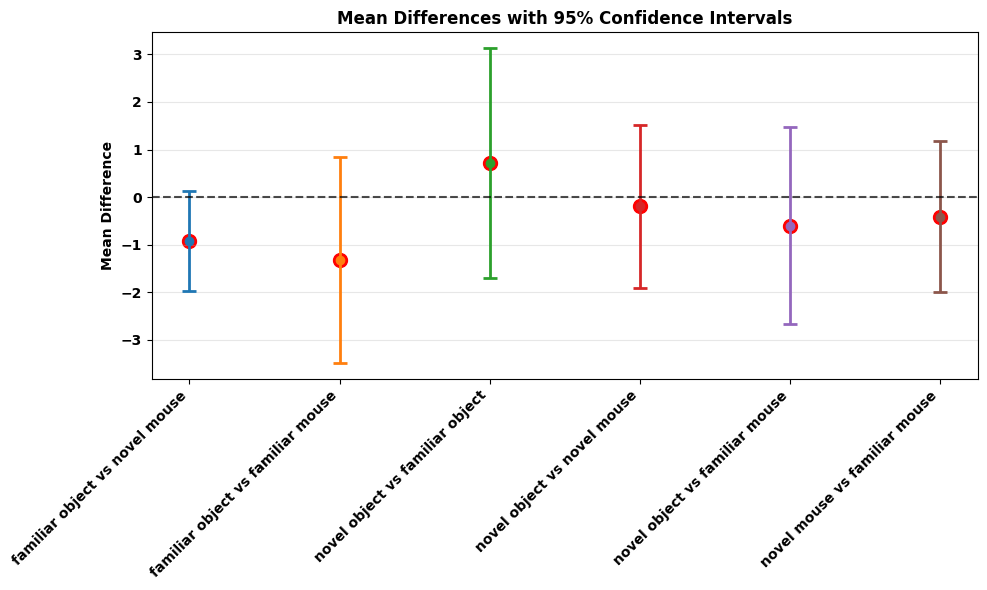

                          Comparison  t-statistic   p-value  p-value (Holm)  \
3     familiar object vs novel mouse    -2.246993  0.074558        0.447346   
4  familiar object vs familiar mouse    -1.573108  0.176504        0.882518   
0    novel object vs familiar object     0.769888  0.476147        1.000000   
1        novel object vs novel mouse    -0.291058  0.782694        1.000000   
2     novel object vs familiar mouse    -0.743865  0.490416        1.000000   
5      novel mouse vs familiar mouse    -0.660512  0.538137        1.000000   

   Significant  Mean Difference  CI Lower  CI Upper  
3        False        -0.915117 -1.962021  0.131786  
4        False        -1.320970 -3.479538  0.837599  
0        False         0.721989 -1.688664  3.132642  
1        False        -0.193128 -1.898808  1.512552  
2        False        -0.598981 -2.668885  1.470924  
5        False        -0.405852 -1.985351  1.173646  


In [103]:
results = paired_ttest_with_holm(avg_event_long_df, conditions, subject_col='level_0', value_col='time')
print(results)

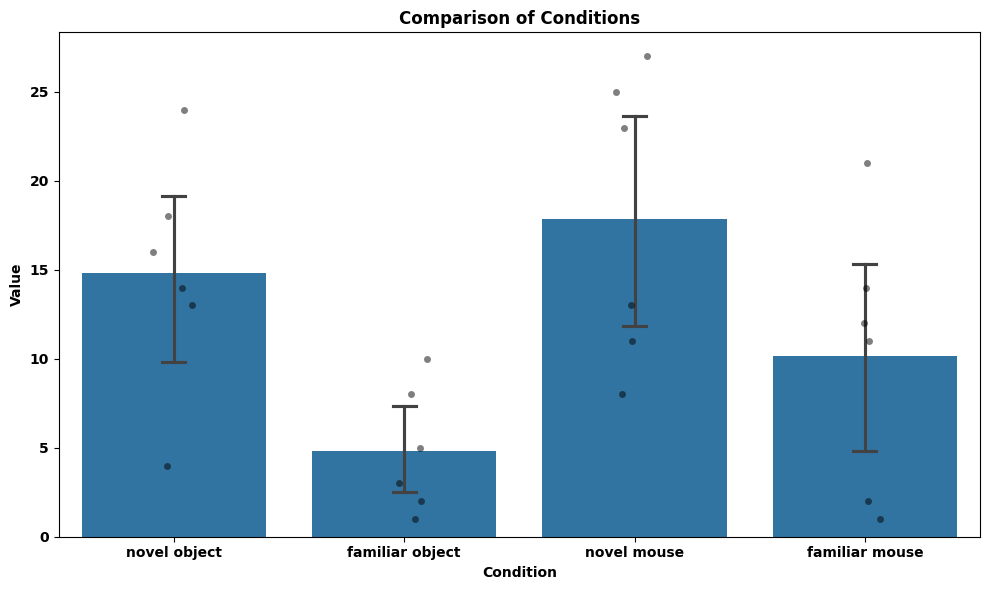

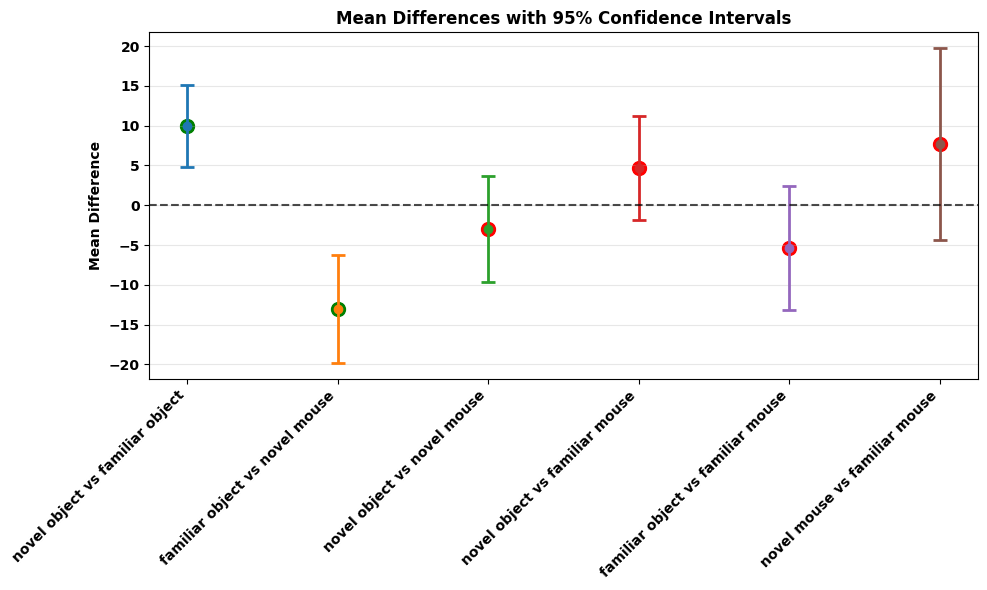

                          Comparison  t-statistic   p-value  p-value (Holm)  \
0    novel object vs familiar object     5.000000  0.004105        0.024628   
3     familiar object vs novel mouse    -4.913538  0.004422        0.024628   
1        novel object vs novel mouse    -1.156129  0.299865        0.501692   
2     novel object vs familiar mouse     1.838290  0.125423        0.501692   
4  familiar object vs familiar mouse    -1.760475  0.138638        0.501692   
5      novel mouse vs familiar mouse     1.630427  0.163940        0.501692   

   Significant  Mean Difference   CI Lower   CI Upper  
0         True        10.000000   4.858836  15.141164  
3         True       -13.000000 -19.801120  -6.198880  
1        False        -3.000000  -9.670317   3.670317  
2        False         4.666667  -1.858989  11.192323  
4        False        -5.333333 -13.120872   2.454205  
5        False         7.666667  -4.420840  19.754173  


In [104]:
results = paired_ttest_with_holm(no_events_long_df, conditions, subject_col='level_0', value_col='no of events')
print(results)

In [105]:
pickle_this(behavior_dicts, 'pilot2/object_behavior_dicts.pkl')